In [526]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [527]:
loans = pd.DataFrame.from_csv('lending-club-data.csv')

In [528]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
del loans['bad_loans']
target = 'safe_loans'
loans = loans[features + [target]]
loans = loans.reset_index(drop=True)
loans = pd.get_dummies(loans)

In [529]:
train_data = loans.ix[pd.read_json('module-8-assignment-2-train-idx.json')[0]].reset_index(drop=True)

In [530]:
test_data = loans.ix[pd.read_json('module-8-assignment-2-test-idx.json')[0]].reset_index(drop=True)

In [588]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    data_weights[labels_in_node == +1]
    ##print(labels_in_node.shape)
    #print(data_weights.shape)
    total_weight_positive = sum(data_weights[labels_in_node == +1])

    weighted_mistakes_all_negative = total_weight_positive
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    weighted_mistakes_all_positive = total_weight_negative
    
    if weighted_mistakes_all_positive <= weighted_mistakes_all_negative:
        return weighted_mistakes_all_positive, 1
    return weighted_mistakes_all_negative, -1

In [589]:
# Test intermediate_node_weighted_mistakes
labels_in_node = np.array([1, 1, -1, -1, 1])
data_weights = np.array([1, 1, 1, 1, 1])
assert (2, 1) == intermediate_node_weighted_mistakes(labels_in_node, data_weights)

In [847]:
# Quiz Question: If we set the weights α=1 for all data points, how is the weight of 
# mistakes WM(α,y^) related to the classification error?

# WM * N = classification error

In [693]:
def best_splitting_feature(data, features, target, data_weights):
    best_feature = None
    best_error = float('+inf')
    num_points = float(len(data))
    
    for feature in features:
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
        
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(
            left_split[target].as_matrix(), left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(
            right_split[target].as_matrix(), right_data_weights)
        weighted_error = (left_weighted_mistakes + right_weighted_mistakes) / np.sum(data_weights)
        
        if weighted_error < best_error:
            best_feature = feature
            best_error = weighted_error
            
    return best_feature

In [694]:
class Node:
    def __init__(self, is_leaf=False, prediction=None, left=None, right=None, splitting_feature=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.left = left
        self.right = right
        self.splitting_feature = splitting_feature

In [695]:
def create_leaf(target_values, data_weights):
    leaf = Node(is_leaf=True)
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    
    leaf.prediction = best_class
    return leaf

In [696]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth=1, max_depth=10):
    remaining_features = features[:]
    target_values = data[target]
    
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    assert len(data) == len(data_weights), "Data {} weights {}".format(len(data), len(data_weights))
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")
        return create_leaf(target_values, data_weights)
    if len(remaining_features) == 0:
        print("Stopping condition 2 reached.")
        return create_leaf(target_values, data_weights)
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
    
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[(data[splitting_feature] == 0).as_matrix()]
    right_data_weights = data_weights[(data[splitting_feature] == 1).as_matrix()]
    
    print("Split on feature {}. ({}, {})".format(splitting_feature, len(left_split), len(right_split)))
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target].as_matrix(), left_data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target].as_matrix(), right_data_weights)
    
    assert len(left_split) == len(left_data_weights), "left split {} left_data_weights {}".format(left_split.shape, left_data_weights.shape)
    left_tree = weighted_decision_tree_create(left_split, remaining_features, target, left_data_weights, 
                                              current_depth+1, max_depth)
    right_tree = weighted_decision_tree_create(right_split, remaining_features, target, right_data_weights,
                                              current_depth+1, max_depth)
    
    return Node(left=left_tree, right=right_tree, splitting_feature=splitting_feature)

In [697]:
def count_nodes(tree):
    if tree.is_leaf:
        return 1
    return 1 + count_nodes(tree.left) + count_nodes(tree.right)

In [715]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree.is_leaf:
        if annotate: 
            print("At leaf, predicting %s" % tree.prediction)
        return tree.prediction
    else:
        # Split on feature.
        split_feature_value = x[tree.splitting_feature]
        if annotate: 
            print("Split on %s = %s" % (tree.splitting_feature, split_feature_value))
        if split_feature_value == 0:
            return classify(tree.left, x, annotate)
        else:
            return classify(tree.right, x, annotate)

In [699]:
def evaluate_classification_error(tree, data, target):
    prediction = data.apply(lambda x: classify(tree, x), axis=1)
    return np.sum(prediction != data[target]) / float(len(data))

In [700]:
new_features = train_data.columns.values.tolist()
new_features.remove(target)

In [701]:
example_data_weights = np.zeros(len(train_data))
example_data_weights[:10] = 1
example_data_weights[-10:] = 1

In [704]:
subset_20 = weighted_decision_tree_create(train_data, new_features, target, example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Split on feature grade_A. (9122, 101)
--------------------------------------------------------------------
Subtree, depth = 3 (9122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (101 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Split on feature grade_D. (23300, 4701)
--------------------------------------------------------------------
Subtree, depth = 3 (23300 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (4701 data points).
Stop

In [705]:
evaluate_classification_error(subset_20, train_data, target)

0.4963464431549538

In [835]:
# Adaboost
from math import log
from math import exp

def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    weights = np.ones(len(data))
    target_values = data[target]
    weight_list = []
    models = []
    
    for i in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % i)
        print('=====================================================')
        tree = weighted_decision_tree_create(data, features, target, weights, max_depth=1)
        models.append(tree)
        
        predictions = data.apply(lambda x: classify(tree, x), axis=1)
        is_correct = predictions == target_values
        is_wrong = (predictions != target_values).as_matrix()
        weighted_error = np.sum(is_wrong * weights) / np.sum(weights)
        model_weight = 0.5 * log((1-weighted_error) / weighted_error)
        weight_list.append(model_weight)
        adjustments = is_correct.apply(lambda x: exp(-1 * model_weight) if x else exp(model_weight))
        
        weights = weights * adjustments
        weights = weights / np.sum(weights)

    return weight_list, models

In [836]:
weights, models = adaboost_with_tree_stumps(train_data, new_features, target, 10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
-------------------------

In [837]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = np.zeros(len(data))
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x), axis=1)
        weighted_predictions = stump_weights[i] * predictions
        scores += weighted_predictions
    ones = np.ones(len(scores))
    np.place(ones, scores < 0, -1)
    return ones

In [846]:
# Quiz Question: Are the weights monotonically decreasing, monotonically increasing, or neither?

weights

[0.0073072437460504035,
 0.15426095659895542,
 0.18126425822680578,
 0.09157648000044605,
 0.07249406442311306,
 0.06910952984001668,
 0.0643810236657579,
 0.05354699200660931,
 0.04288608079004245,
 0.028570820003680716]

In [737]:
weights_30, models_30 = adaboost_with_tree_stumps(train_data, new_features, target, 30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
1.0
1.0073340068
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (37224 data points).
Split on feature term_ 36 months. (9223, 28001)
--------------------------------------------------------------------
Subtree, depth = 2 (9223 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (28001 data points).
Reached maximum depth. Stopping for now.
2.70621346612e-05
0.857048339

In [843]:
error_all = []
for i in range(1, len(weights_30)+1):
    predictions = predict_adaboost(weights_30[:i], models_30[:i], train_data)
    error = 1 - np.sum(predictions == train_data[target]) / float(len(train_data))
    error_all.append(error)
    print("Iteration %s, training error = %s" % (i, error_all[i-1]))

Iteration 1, training error = 0.496346443155
Iteration 2, training error = 0.421636578551
Iteration 3, training error = 0.433430045132
Iteration 4, training error = 0.400037610144
Iteration 5, training error = 0.404953793252
Iteration 6, training error = 0.384724908661
Iteration 7, training error = 0.384617451107
Iteration 8, training error = 0.382763808296
Iteration 9, training error = 0.384617451107
Iteration 10, training error = 0.382763808296
Iteration 11, training error = 0.382736943907
Iteration 12, training error = 0.382736943907
Iteration 13, training error = 0.381447453256
Iteration 14, training error = 0.381528046422
Iteration 15, training error = 0.38042660649
Iteration 16, training error = 0.380507199656
Iteration 17, training error = 0.378277455405
Iteration 18, training error = 0.378975929508
Iteration 19, training error = 0.378196862239
Iteration 20, training error = 0.378062540297
Iteration 21, training error = 0.378761014399
Iteration 22, training error = 0.37956694605

In [741]:
import matplotlib.pyplot as plt

%matplotlib inline

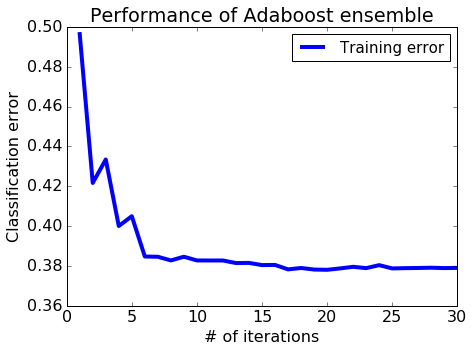

In [742]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [839]:
# Quiz Question: Which of the following best describes a general trend in accuracy as we 
# add more and more components? Answer based on the 30 components learned so far.

In [844]:
test_error_all = []
for i in range(1, len(weights_30)+1):
    predictions = predict_adaboost(weights_30[:i], models_30[:i], test_data)
    error = 1 - np.sum(predictions == test_data[target]) / float(len(test_data))
    test_error_all.append(error)
    print("Iteration %s, test error = %s" % (i, test_error_all[i-1]))

Iteration 1, test error = 0.503446790177
Iteration 2, test error = 0.42330891857
Iteration 3, test error = 0.428479103835
Iteration 4, test error = 0.398104265403
Iteration 5, test error = 0.398211977596
Iteration 6, test error = 0.379900904782
Iteration 7, test error = 0.380008616975
Iteration 8, test error = 0.379254631624
Iteration 9, test error = 0.380008616975
Iteration 10, test error = 0.379254631624
Iteration 11, test error = 0.379254631624
Iteration 12, test error = 0.379254631624
Iteration 13, test error = 0.377962085308
Iteration 14, test error = 0.379254631624
Iteration 15, test error = 0.377962085308
Iteration 16, test error = 0.378500646273
Iteration 17, test error = 0.377962085308
Iteration 18, test error = 0.376669538992
Iteration 19, test error = 0.378069797501
Iteration 20, test error = 0.378177509694
Iteration 21, test error = 0.376884963378
Iteration 22, test error = 0.377531236536
Iteration 23, test error = 0.376777251185
Iteration 24, test error = 0.376130978027
It

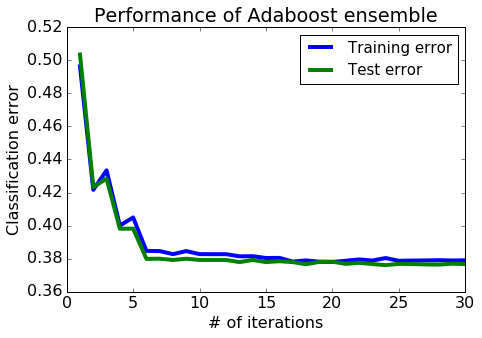

In [845]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()